# Analysis of vulnerabilities in the Rust ecosystem

This notebook analyses the prevelance and types of vulnerabilities found in packages published by `Cargo`.

In [2]:
from typing import Union
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvss import CVSS2, CVSS3 # converts CVSS strings to score

## Data Aggregation

Note: this data was pulled on 10/28/2023.

In [3]:
def convert_severity(severity) -> int:
    """Assumes severity is of form {"type": ..., "score": ... }"""
    if severity["type"] == "CVSS_V3":
        return CVSS3(severity["score"]).scores()[0]
    else:
        return CVSS2(severity["score"]).scores()[0]


def clean_data(data):
    del data["aliases"]
    if len(data["severity"]) > 0:
        data["severity"] = convert_severity(data["severity"][0])
    else:
        data["severity"] = None
    data_affected = data["affected"][0]
    data["affected_name"] = data_affected["package"]["name"]
    data["categories"] = data_affected["database_specific"]["categories"]
    data["affected_info"] = data_affected["database_specific"]["informational"]
    data["events"] = data_affected["ranges"][0]["events"]
    del data["affected"]

    data["reference"] = data["references"][1]["url"]
    del data["references"]
    del data["database_specific"]

def json_to_osv(file_path: str) -> Union[pd.DataFrame, None]:
    """Given a file path to a json file in the OSV format, returns a populated dataframe."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    if "withdrawn" in data:
        return None
    clean_data(data)
    df = pd.DataFrame.from_dict(data, orient="index").T
    df = df.astype({'severity': 'Float32'})
    df = df.astype({'summary': 'string'})
    df = df.astype({'details': 'string'})
    df = df.astype({'affected_name': 'string'})
    df = df.astype({'affected_info': 'category'})
    return df
    

In [4]:
# Folder containing RustSec advisories in the OSV format
folder_path = './advisory-db-osv/crates/'

# Read in all vulnerabilities
dataframes = []
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        # Construct the full path to the JSON file
        file_path = os.path.join(folder_path, filename)
        # Read the JSON file into a DataFrame
        osv = json_to_osv(file_path)
        if osv is not None:
            dataframes.append(json_to_osv(file_path))
        
# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

## Data Analysis

### General Stats

In [10]:
num_vul = df.shape[0]
print(f"Number of vulnerabilities: {num_vul}")

Number of vulnerabilities: 548


### CVSS Scores

Number of vulnerabilities without score: 283, that's 0.52%.
Average CVSS score: 7.650567531585693
Standard deviation of CVSS score: 1.6147081851959229


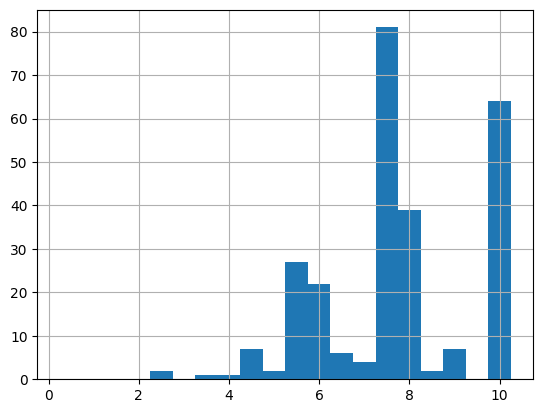

In [20]:
print(f"Number of vulnerabilities without score: {df['severity'].isna().sum()}, that's {round(df['severity'].isna().sum() / df.shape[0], 2)}%.")
df['severity'].hist(bins=np.linspace(0.25,10.25,21))
print(f"Average CVSS score: {df['severity'].mean()}")
print(f"Standard deviation of CVSS score: {df['severity'].std()}")

### Maintenance

In [15]:
num_unmain = df['affected_info'].value_counts()['unmaintained']
print(f"Num of vulnerabilities affecting unmaintained packages: {num_unmain}, that's {round(num_unmain / num_vul, 2)}%.")

Num of vulnerabilities affecting unmaintained packages: 100, that's 0.18%.


### Vulnerability Types

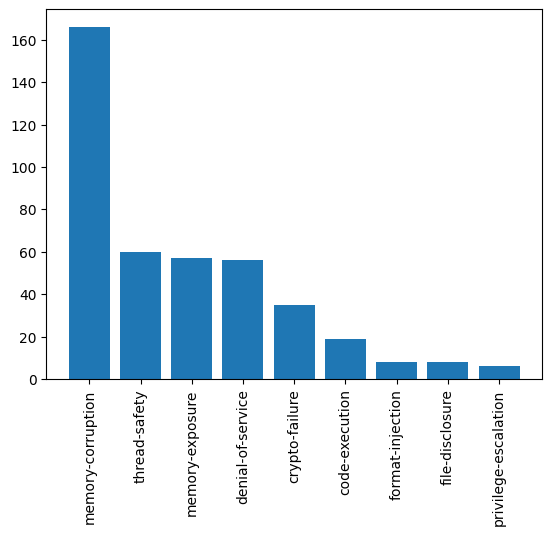

In [29]:
from collections import Counter

def get_type_counts(data):
    counts = Counter()
    for category in data["categories"]:
        counts += Counter(category)
    return counts

type_counts = get_type_counts(df)
type_counts = list(zip(*type_counts.most_common()))
plt.bar(type_counts[0], type_counts[1])
plt.xticks(rotation='vertical')
plt.show()

### Patches